This converts `fingerprints.npy` to `.tsv` formatted t-SNE embeddings and plots of those embeddings in the `tsne/` and `plot/` folders respectively. If you add multiple values to `perplexity` and `initial_dims` then all combinations will be computed (in parallel). Good perplexities are in the range 1-200 with the best range around 30-100. Good `initial_dims` are in the range 30 and higher, with the dimensionality of your input data being the highest possible value (e.g., a 32x32 fingerprint would have a highest possible `initial_dims` value of 32x32=1024).

Change the "mode" to try different t-SNE variations.
* "fingerprints" will only use `fingerprints.npy`
* "predicted_labels" will only use `predicted_labels.npy`
* "predicted_encoding" will only use `predicted_encoding.npy`
* "combined" will use all of the above data

In [ ]:
data_root = 'data/drums/'
initial_dims = [30]
perplexities = [30]
mode = 'fingerprints'
# mode = 'predicted_labels'
# mode = 'predicted_encoding'
# mode = 'combined'

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
from time import time
from utils import *
from os.path import join
from multiprocessing import Pool
import numpy as np
import itertools

In [ ]:
def save_tsv(data, fn):
    np.savetxt(fn, data, fmt='%.5f', delimiter='\t')
def tsne(data, data_root, prefix, initial_dims=30, perplexity=30):
    mkdir_p(data_root + 'tsne')
    mkdir_p(data_root + 'plot')

    figsize = (16,16)
    pointsize = 2

    X_2d = list(bh_tsne(data, initial_dims=initial_dims, perplexity=perplexity, no_dims=2))
    X_2d = normalize(np.array(X_2d))
    save_tsv(X_2d, join(data_root, 'tsne/{}.{}.{}.2d.tsv'.format(prefix, initial_dims, perplexity)))

    plt.figure(figsize=figsize)
    plt.scatter(X_2d[:,0], X_2d[:,1], edgecolor='', s=pointsize)
    plt.tight_layout()
    plt.savefig(join(data_root, 'plot/{}.{}.{}.png'.format(prefix, initial_dims, perplexity)))
    plt.close()

    X_3d = list(bh_tsne(data, initial_dims=initial_dims, perplexity=perplexity, no_dims=3))
    X_3d = normalize(np.array(X_3d))
    save_tsv(X_3d, join(data_root, 'tsne/{}.{}.{}.3d.tsv'.format(prefix, initial_dims, perplexity)))

    plt.figure(figsize=figsize)
    plt.scatter(X_2d[:,0], X_2d[:,1], edgecolor='', s=pointsize, c=X_3d)
    plt.tight_layout()
    plt.savefig(join(data_root, 'plot/{}.{}.{}.png'.format(prefix, initial_dims, perplexity)))
    plt.close()

In [ ]:
# load and normalize any dataset we need
if mode == 'fingerprints' or mode == 'combined':
    fingerprints = np.load(join(data_root, 'fingerprints.npy'))
    fingerprints = fingerprints.reshape(len(fingerprints), -1)
if mode == 'predicted_labels' or mode == 'combined':
    predicted_labels = np.load(join(data_root, 'predicted_labels.npy'))
    predicted_labels -= predicted_labels.min()
    predicted_labels /= predicted_labels.max()
if mode == 'predicted_encoding' or mode == 'combined':
    predicted_encoding = np.load(join(data_root, 'predicted_encoding.npy'))
    std = predicted_encoding.std(axis=0)
    predicted_encoding = predicted_encoding[:, std > 0] / std[std > 0]

if mode == 'fingerprints':
    data = fingerprints
if mode == 'predicted_labels':
    data = predicted_labels
if mode == 'predicted_encoding':
    data = predicted_encoding
if mode == 'combined':
    data = np.hstack((fingerprints, predicted_labels, predicted_encoding))

print data.shape

In [ ]:
data = data.astype(np.float64)
def job(params):
    start = time()
    tsne(data, data_root, mode, initial_dims=params[0], perplexity=params[1])
    print 'initial_dims={}, perplexity={}, {} seconds'.format(params[0], params[1], time() - start)
params = list(itertools.product(initial_dims, perplexities))
pool = Pool()
pool.map(job, params)

## My adapted code to run a simple t-SNE

This was not directly based on Kyle McDonald's Audio Notebooks. Instead, it was based on some of his linked notebooks, particularly CloudToGrid which is linked in the bottom of the README.md for Audio Notebooks.

In [ ]:
import numpy as np
from sklearn import manifold
from matplotlib import pyplot as plt
%matplotlib inline
import lap
import hungarian

In [3]:
# @title Load the embeddings
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
import time
import os

EMBEDDINGS_FILE = 'vocalsound_hear_embeddings.npy'
METADATA_FILE = 'vocalsound_hear_metadata.csv'
TSNE_FILE = 'vocalsound_tsne_data_final.csv'

try:
    embeddings = np.load(EMBEDDINGS_FILE)
    metadata_df = pd.read_csv(METADATA_FILE)
    print(f"Loaded embeddings: {embeddings.shape}")
    print(f"Loaded metadata: {metadata_df.shape}")
except FileNotFoundError as e:
    print(f"Error: Could not find data files. Ensure '{EMBEDDINGS_FILE}' and '{METADATA_FILE}' exist.")
    raise e

Loaded embeddings: (20237, 512)
Loaded metadata: (20237, 10)


In [7]:
# --- 2. Configure t-SNE Parameters ---

# HeAR output is 512D. Your data size is N=20237.
# For N > 5000, t-SNE can be slow and often benefits from initial PCA.

# Use your full dimensionality as the initial_dims parameter is not needed by scikit-learn
# when not using initial PCA.
INITIAL_DIMS = embeddings.shape[1]  # 512

# Perplexity: A key parameter. Range 5 to 50 is standard.
# The bird sounds reference suggests a wider range (30-100 is often good for large datasets).
# TODO: Find out where it says that
# We'll use a robust starting point.
PERPLEXITY = 50

# Iterations: 2500-3000 is often good for convergence.
N_ITER = 3000

# Ensures the same plot every time
RANDOM_STATE = 42

print(f"\nTSNE Parameters: Initial Dims={INITIAL_DIMS}, Perplexity={PERPLEXITY}, Iterations={N_ITER}")

# --- 3. Perform t-SNE Dimensionality Reduction ---
print("Starting t-SNE calculation...")
start_time = time.time()

tsne = TSNE(
    n_components=2,
    perplexity=PERPLEXITY,
    max_iter=N_ITER,
    random_state=RANDOM_STATE,
    metric='cosine', # Cosine distance is often better for embeddings than Euclidean
    verbose=1
)

# Run t-SNE
tsne_coordinates = tsne.fit_transform(embeddings)

# Normalize -- not necessary, but makes it easier to visualize results
tsne_coordinates -= tsne_coordinates.min(axis=0)
tsne_coordinates /= tsne_coordinates.max(axis=0)

end_time = time.time()
print(f"t-SNE calculation finished in: {end_time - start_time:.2f} seconds.")
print(f"t-SNE coordinates shape: {tsne_coordinates.shape}")

# --- 4. Merge Coordinates and Prepare Final Output ---

# 4.1. Add the 2D t-SNE coordinates (x, y) to the DataFrame
metadata_df['tsne_x'] = tsne_coordinates[:, 0]
metadata_df['tsne_y'] = tsne_coordinates[:, 1]

# 4.2. Select only the columns needed for the visualization
# This ensures a clean data file for your web UI.
final_columns = [
    'tsne_x',
    'tsne_y',
    'sound_type',     # The acoustic event (e.g., 'cough', 'laughter')
    'file_name',      # Used to link back to the audio file for playback
    'gender',         # Additional metadata for filtering/tooltips
    'age',
    'country'
]

# Ensure we only include columns that actually exist in your metadata
final_df = metadata_df[[col for col in final_columns if col in metadata_df.columns]]

# --- 5. Save the Final Data File ---
final_df.to_csv(TSNE_FILE, index=False)
print(f"Successfully saved final visualization data to: {TSNE_FILE}")
print("Final data structure (first 5 rows):")
print(final_df.head())


TSNE Parameters: Initial Dims=512, Perplexity=50, Iterations=3000
Starting t-SNE calculation...
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 20237 samples in 0.004s...
[t-SNE] Computed neighbors for 20237 samples in 5.658s...
[t-SNE] Computed conditional probabilities for sample 1000 / 20237
[t-SNE] Computed conditional probabilities for sample 2000 / 20237
[t-SNE] Computed conditional probabilities for sample 3000 / 20237
[t-SNE] Computed conditional probabilities for sample 4000 / 20237
[t-SNE] Computed conditional probabilities for sample 5000 / 20237
[t-SNE] Computed conditional probabilities for sample 6000 / 20237
[t-SNE] Computed conditional probabilities for sample 7000 / 20237
[t-SNE] Computed conditional probabilities for sample 8000 / 20237
[t-SNE] Computed conditional probabilities for sample 9000 / 20237
[t-SNE] Computed conditional probabilities for sample 10000 / 20237
[t-SNE] Computed conditional probabilities for sample 11000 / 20237
[t-SNE] Computed con

In [8]:
# @title Load the data from vocalsound_tsne_data_final.csv

FINAL_DATA_FILE = 'vocalsound_tsne_data_final.csv'

try:
    final_df = pd.read_csv(FINAL_DATA_FILE)
    print(f"Loaded final data from: {FINAL_DATA_FILE}")
    print(f"Data shape: {final_df.shape}")
    print("First 5 rows:")
    print(final_df.head())
except FileNotFoundError:
    print(f"Error: The file '{FINAL_DATA_FILE}' was not found.")

Loaded final data from: vocalsound_tsne_data_final.csv
Data shape: (20237, 7)
First 5 rows:
     tsne_x    tsne_y      sound_type               file_name   gender  age  \
0  0.835166  0.303017            sigh            f1236_0_sigh   female   27   
1  0.782971  0.633874  throatclearing  f1541_0_throatclearing   female   25   
2  0.668308  0.036523           sniff           m1679_0_sniff     male   34   
3  0.792297  0.686088  throatclearing  m1783_0_throatclearing     male   19   
4  0.122311  0.520460        laughter        f1291_0_laughter   female   23   

  country  
0      EN  
1      EN  
2      EN  
3      AR  
4      IT  



Generating t-SNE scatter plot...


/var/folders/pn/7ysbjdfn4h3ddgnl7ymjpf5r0000gn/T/ipykernel_9597/2295919800.py:16: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(
/var/folders/pn/7ysbjdfn4h3ddgnl7ymjpf5r0000gn/T/ipykernel_9597/2295919800.py:30: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Sound Type", bbox_to_anchor=(1.05, 1), loc='upper left') # Place legend outside the plot


Plot saved to: tsne_visualization.png


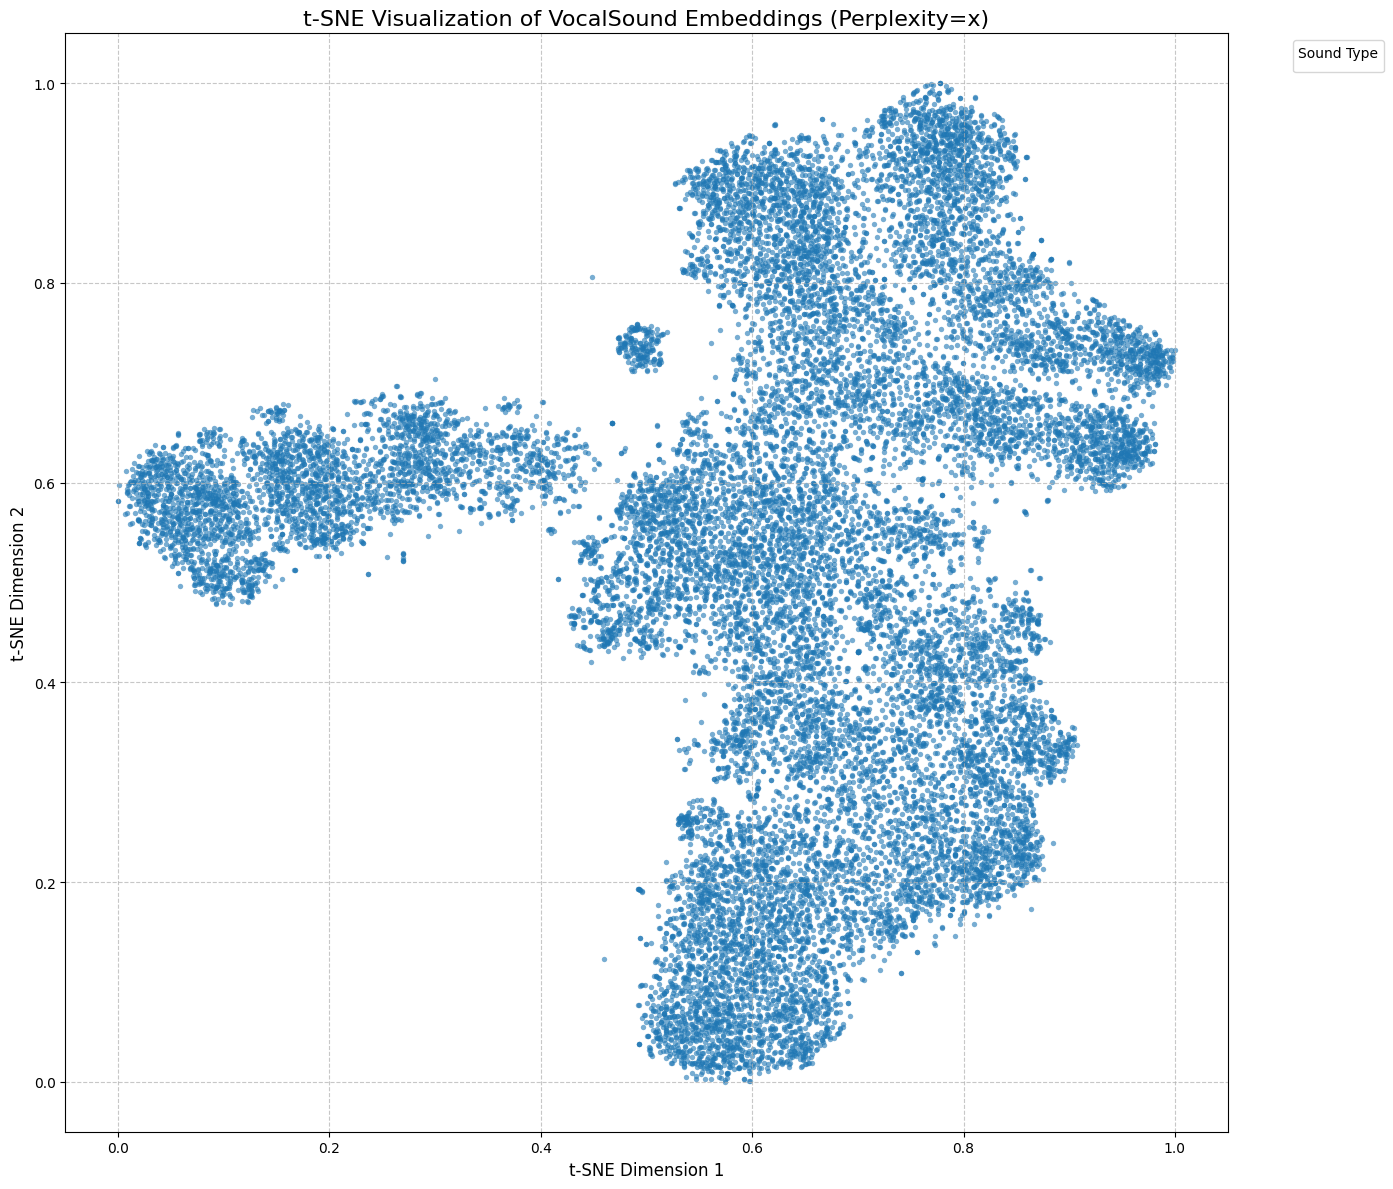


Plotting complete. You can now view the image file or the displayed plot.


In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

PLOT_FILE = 'tsne_visualization.png' # Where to save the plot

print("\nGenerating t-SNE scatter plot...")

plt.figure(figsize=(14, 12)) # Adjust figure size for better visibility

# Use Seaborn's scatterplot for automatic coloring by 'sound_type'
# The `hue` parameter automatically assigns different colors to different categories
# The `s` parameter controls marker size
# `alpha` makes points semi-transparent, useful for dense plots
sns.scatterplot(
    x='tsne_x',
    y='tsne_y',
    data=final_df,
    s=15,             # Size of the points
    alpha=0.6,        # Transparency of the points
    linewidth=0,      # No border around points
    palette='deep'    # Choose a color palette
)

plt.title(f"t-SNE Visualization of VocalSound Embeddings (Perplexity={final_df['tsne_x'].name.split('_')[-1] if 'tsne_x' in final_df.columns else 'N/A'})", fontsize=16)
plt.xlabel("t-SNE Dimension 1", fontsize=12)
plt.ylabel("t-SNE Dimension 2", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title="Sound Type", bbox_to_anchor=(1.05, 1), loc='upper left') # Place legend outside the plot
plt.tight_layout() # Adjust layout to prevent labels/legend from overlapping

# --- 3. Save the plot to a file ---
plt.savefig(os.path.join("plots", PLOT_FILE), dpi=300) # Save with high resolution
print(f"Plot saved to: {PLOT_FILE}")

# --- 4. Display the plot (optional, for Jupyter/Colab) ---
plt.show()

print("\nPlotting complete. You can now view the image file or the displayed plot.")


Generating t-SNE scatter plot...
Plot saved to: tsne_visualization.png


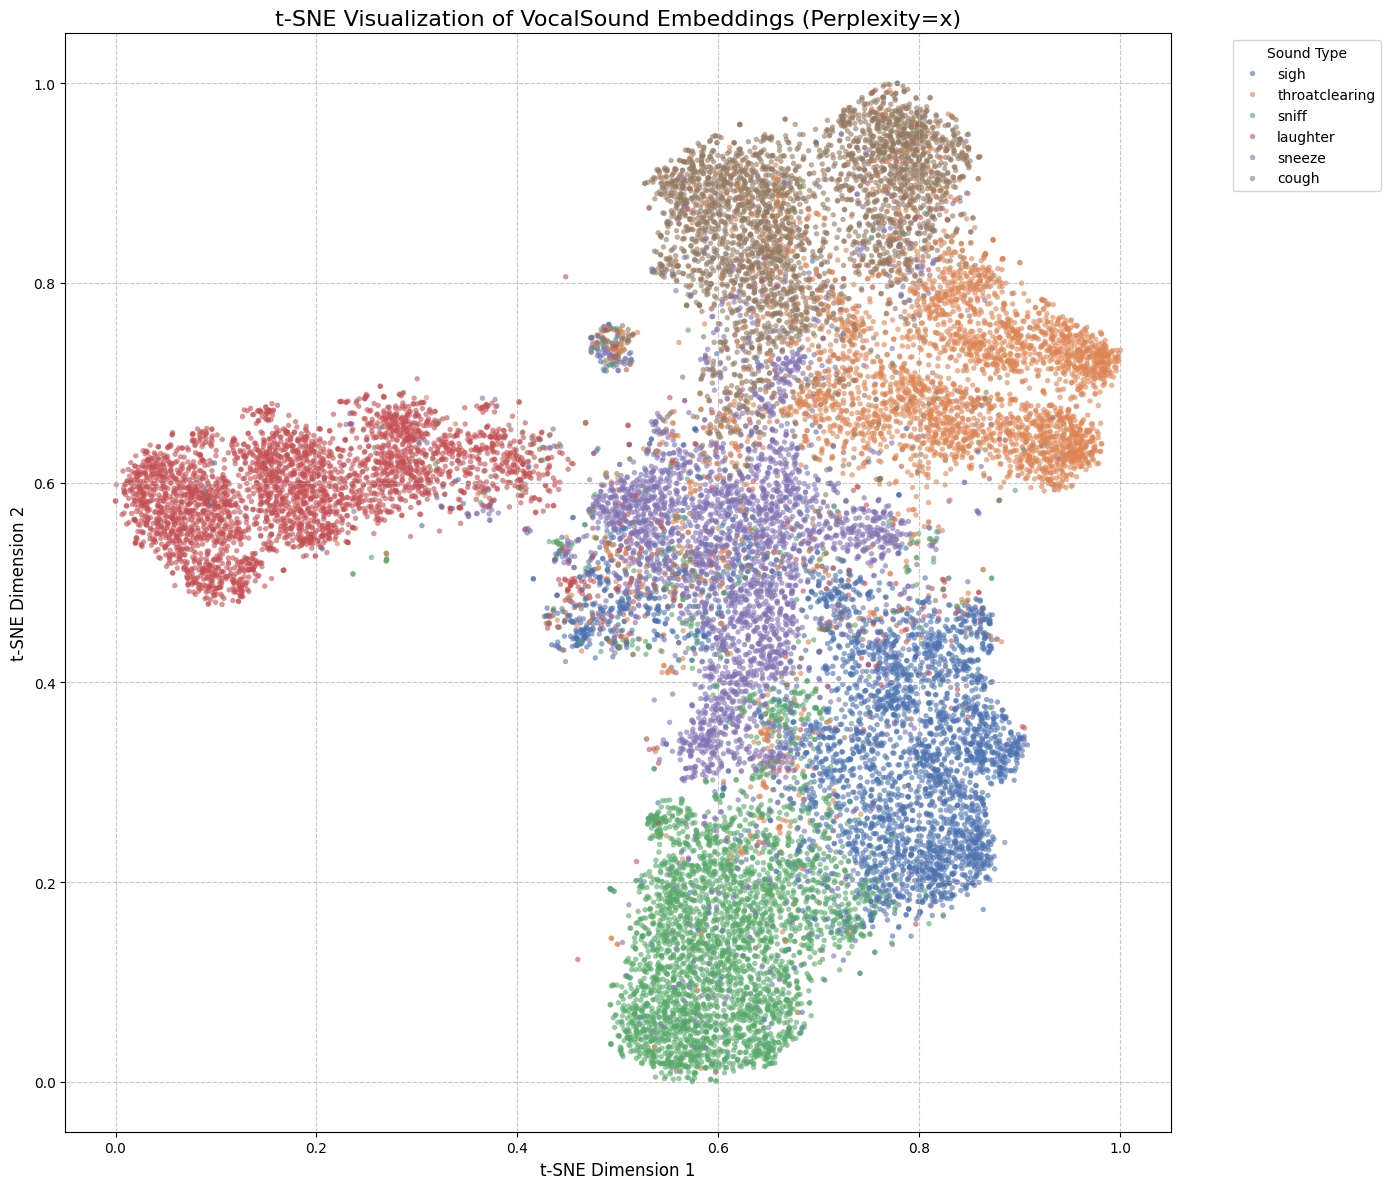


Plotting complete. You can now view the image file or the displayed plot.


In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

PLOT_FILE = 'tsne_visualization.png' # Where to save the plot

print("\nGenerating t-SNE scatter plot...")

plt.figure(figsize=(14, 12)) # Adjust figure size for better visibility

# Use Seaborn's scatterplot for automatic coloring by 'sound_type'
# The `hue` parameter automatically assigns different colors to different categories
# The `s` parameter controls marker size
# `alpha` makes points semi-transparent, useful for dense plots
sns.scatterplot(
    x='tsne_x',
    y='tsne_y',
    hue='sound_type', # Color points by the acoustic event type
    data=final_df,
    s=15,             # Size of the points
    alpha=0.6,        # Transparency of the points
    linewidth=0,      # No border around points
    palette='deep'    # Choose a color palette
)

plt.title(f"t-SNE Visualization of VocalSound Embeddings (Perplexity={final_df['tsne_x'].name.split('_')[-1] if 'tsne_x' in final_df.columns else 'N/A'})", fontsize=16)
plt.xlabel("t-SNE Dimension 1", fontsize=12)
plt.ylabel("t-SNE Dimension 2", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title="Sound Type", bbox_to_anchor=(1.05, 1), loc='upper left') # Place legend outside the plot
plt.tight_layout() # Adjust layout to prevent labels/legend from overlapping

# --- 3. Save the plot to a file ---
plt.savefig(os.path.join("plots", PLOT_FILE), dpi=300) # Save with high resolution
print(f"Plot saved to: {PLOT_FILE}")

# --- 4. Display the plot (optional, for Jupyter/Colab) ---
plt.show()

print("\nPlotting complete. You can now view the image file or the displayed plot.")

#### Visualizations

We wish to see how well this t-SNE performs. Let's plot the points based on their attributes, and see
if they cluster well

### Convert the t-SNE embeddings into 2D grid